# Init

In [1]:
import gzip
import numpy
import numpy as np
import scipy
import PIL.Image as Image
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
import time

In [2]:
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()

# np.dtype not accepted, only tf.dtype

Only accepts tf dtype, not np dtype

In [3]:
tf.constant(0.1, dtype=np.float32)

AttributeError: type object 'numpy.float32' has no attribute 'as_datatype_enum'

Suggestion: support numpy dtypes like TF classic

# Can't multiply by python scalar because of device crossing

In [12]:
val = tf.ones(()).as_gpu_tensor()
val*2

InvalidArgumentError: cannot compute Mul as input #1 was expected to be on /job:localhost/replica:0/task:0/device:GPU:0 but is actually on /job:localhost/replica:0/task:0/cpu:0 (operation running on /job:localhost/replica:0/task:0/device:GPU:0) [Op:Mul] name: mul/

Suggestion: follow semantics of TF Classic. The op is executed on a suitable device (ie, heuristics in placer.cc), cross-device copies added automatically

# Missing item assignment in variables

In [20]:
var = resource_variable_ops.ResourceVariable([1,2,3])
print(val[0])
var[0]=2

tf.Tensor([ 1.  1.  1.], shape=(3,), dtype=float32)


TypeError: 'ResourceVariable' object does not support item assignment

Suggestion: override `__setitem__` to call scatter_update on the variable

# Missing item assignment in tensors

In [19]:
val = tf.ones((3,3)).as_gpu_tensor()
val[0]=2

TypeError: 'EagerTensor' object does not support item assignment

In [15]:
import torch
val = torch.ones((3, 3)).cuda()

In [18]:
val[0]=2
val


 2  2  2
 1  1  1
 1  1  1
[torch.cuda.FloatTensor of size 3x3 (GPU 0)]

Suggestion: numpy/torch can do it, why not tf?

# Eager tensors don't behave as numeric types

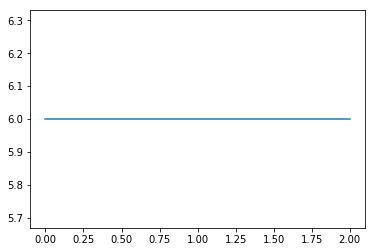

In [80]:
%matplotlib inline
losses_numpy = [np.array(6)]*3
plt.plot(losses_numpy)

In [30]:
losses = [tf.reduce_sum([1,2,3])]*3

In [31]:
losses

[<tf.Tensor: id=55, shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: id=55, shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: id=55, shape=(), dtype=int32, numpy=6>]

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)

ValueError: setting an array element with a sequence.

Suggestion: Use Python duck-typing to make this work like with ndarray objects (see: `__array__` and `__array_interface__`)

# Doesn't support direct reading of some common types
(which are supported in numpy)

In [13]:
img = Image.open(os.path.expanduser("~/cat.jpeg"))

Numpy converts PIL images based on the `__array_interface__`

In [14]:
img.__array_interface__.keys()

['shape', 'version', 'data', 'typestr']

In [15]:
np_img = np.array(img)

In [16]:
tf_img = tf.constant(img)

ValueError: Attempt to convert a value (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x195 at 0x11FA461D0>) with an unsupported type (<class 'PIL.JpegImagePlugin.JpegImageFile'>) to a Tensor.

In [3]:
df = pd.DataFrame({'a':[1,2,3,4],'b':[1,2,3,4]})

In [4]:
np.array(df)

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

In [5]:
np.array(df['a'])

array([1, 2, 3, 4])

`pandas.Series` work, but `DataFrames` crash the python process. 

In [6]:
np.array(df['b'])

array([1, 2, 3, 4])

In [7]:
tf.constant(df['b'])

<tf.Tensor: id=0, shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4], dtype=int32)>

In [ ]:
tf.constant(df)

"Kernel appears to have Died!"

# Silent downcasting float64 to float32

In [56]:
x = np.array(2*np.finfo(np.float32).max)
y = tf.constant(2.)
z=x+y
print(z)

tf.Tensor(inf, shape=(), dtype=float32)


In [57]:
x.dtype

dtype('float64')

In [58]:
z.dtype

tf.float32

Suggestion: Follow standard numeric promotion rules

# Silent downcasting of float32 to int32

In [63]:
tf.pow(2, 2.9)

<tf.Tensor: id=97, shape=(), dtype=int32, numpy=4>

In [65]:
tf.reduce_join([["a", "b"], ["c", "d"]], 0)

<tf.Tensor: id=101, shape=(2,), dtype=string, numpy=array([b'ac', b'bd'], dtype=object)>

In [70]:
tf.matrix_band_part(tf.ones((3,3)), np.array(-1).astype(np.int), 0)

<tf.Tensor: id=121, shape=(3, 3), dtype=float32, numpy=
array([[ 1.,  0.,  0.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  1.]], dtype=float32)>

# Lack of automatic promotion of int32 to int64

In [79]:
idx = tf.constant(-1)
tf.matrix_band_part(tf.ones((3,3)), idx, 0)

InvalidArgumentError: cannot compute MatrixBandPart as input #1 was expected to be a int64 tensor but is a int32 tensor [Op:MatrixBandPart]